In [2]:
# https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=fasta&query=%28%28taxonomy_id%3A2%29+AND+%28length%3A%5B*+TO+200%5D%29+NOT+%28existence%3A4%29+NOT+%28reviewed%3Atrue%29+NOT+%28existence%3A3%29%29

import pandas as pd 
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.gridspec import GridSpec
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'

import dataframe_image as dfi

from selenobot.files import XMLFile, KofamscanFile
from selenobot.utils import seed, truncate_sec
from selenobot.datasets import Dataset, get_dataloader
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from tqdm import tqdm
from scipy.stats import false_discovery_control, mannwhitneyu

import warnings 
warnings.simplefilter('ignore')


%load_ext autoreload
%autoreload 2

In [3]:
label_map = dict()
label_map[0] = 'full-length'
label_map[1] = 'trunc. sel.'
label_map[2] = 'short full-len.'

color_map = {1:'tab:red', 2:'tab:blue', 0:'tab:green'}
color_map.update({'train':'tab:red', 'test':'tab:blue', 'val.':'tab:green'})
color_map.update({'evidence at protein level':'tab:green', 'inferred from homology':'tab:blue', 'predicted':'tab:red', 'evidence at transcript level':'tab:green', 'uncertain':'black'})

datasets = ['train', 'test', 'val.']

In [4]:
metadata_2c_df = pd.read_csv('../data/2c_metadata.csv', index_col=0)
metadata_3c_df = pd.read_csv('../data/3c_metadata.csv', index_col=0)
metadata_3c_xl_df = pd.read_csv('../data/3c_xl_metadata.csv', index_col=0)

In [5]:
# metadata_sprot_df = pd.read_csv('../data/uniprot_metadata_sprot.csv', index_col=0, usecols=['id', 'domain', 'seq']) 
# metadata_sprot_df = metadata_sprot_df[metadata_sprot_df.domain == 'Bacteria']

metadata_sec_df = pd.read_csv('../data/uniprot_sec.csv', index_col=0)
metadata_sec_df = metadata_sec_df[metadata_sec_df.domain == 'Bacteria']
metadata_sec_df = metadata_sec_df.merge(KofamscanFile('../data/uniprot_sec_bac.ko.tsv').to_df(), left_index=True, right_index=True, how='left')


In [6]:
def table_1(metadata_sec_df:pd.DataFrame, reduce:bool=False, path:str='../figures/datasets-table_1.png'):

    ko_map = dict()
    ko_map['formate dehydrogenase (hydrogenase) '] = 'formate dehydrogenase'
    ko_map['F420-non-reducing hydrogenase iron-sulfur subunit '] = 'hydrogenase'
    ko_map['formate dehydrogenase (coenzyme F420) alpha subunit '] = 'formate dehydrogenase' 
    ko_map['betaine reductase complex component B subunit beta '] = 'reductase'
    ko_map['NADH-dependent peroxiredoxin subunit C '] = 'peroxiredoxin'
    ko_map['sulfur-carrier protein adenylyltransferase/sulfurtransferase '] = 'adenylyltransferase'
    ko_map['molybdopterin-synthase adenylyltransferase '] = 'adenylyltransferase' 
    ko_map['F420-non-reducing hydrogenase large subunit '] = 'hydrogenase'
    ko_map['formate dehydrogenase (NAD+, ferredoxin) subunit '] = 'formate dehydrogenase'
    ko_map['sarcosine reductase complex component B subunit beta '] = 'reductase'
    ko_map['CoA-dependent NAD(P)H sulfur oxidoreductase '] = 'oxioreductase'
    ko_map['mycoredoxin-dependent peroxiredoxin '] = 'peroxiredoxin'
    ko_map['NFU1 iron-sulfur cluster scaffold homolog, mitochondrial'] = 'other'
    ko_map['regulatory protein spx'] = 'other'
    ko_map['P-type Cu+ transporter '] = 'other'
    ko_map['methane/ammonia monooxygenase subunit A '] = 'monooxygenase' 
    ko_map['glutaredoxin-dependent peroxiredoxin '] = 'peroxiredoxin' 
    ko_map['mycoredoxin '] = 'mycoredoxin'
    ko_map['thioredoxin-dependent peroxiredoxin '] = 'peroxiredoxin'
    ko_map['multidrug efflux pump'] = 'other'
    ko_map['methylamine---corrinoid protein Co-methyltransferase '] = 'methyltransferase' 
    ko_map['nucleoredoxin '] = 'nucleoredoxin'
    ko_map['TetR/AcrR family transcriptional regulator, transcriptional repressor for nem operon'] = 'other'
    ko_map['alcohol dehydrogenase (NADP+) '] = 'dehydrogenase'
    ko_map['sulfonate transport system permease protein'] = 'transport'
    ko_map['3-hydroxy acid dehydrogenase / malonic semialdehyde reductase '] = 'reductase'
    ko_map['alcohol dehydrogenase, propanol-preferring '] = 'dehydrogenase'
    ko_map['arsenical resistance protein ArsH'] = 'other'
    ko_map['tRNA 2-thiocytidine biosynthesis protein TtcA'] = 'other'
    ko_map['quinone-modifying oxidoreductase, subunit QmoA'] = 'oxioreductase'
    ko_map['acetate---CoA ligase (ADP-forming) '] = 'other'
    ko_map['glutaredoxin/glutathione-dependent peroxiredoxin '] = 'peroxiredoxin'
    ko_map['thioredoxin-dependent peroxiredoxin '] = 'peroxiredoxin'
    ko_map['phospholipid scramblase'] = 'other'

    ko_counts = pd.Series(metadata_sec_df.value_counts('ko'), name='count')
    table_df = metadata_sec_df[['ko', 'ko_definition']]
    table_df = table_df.merge(ko_counts, right_index=True, left_on='ko', how='right')
    table_df = table_df.drop_duplicates('ko').set_index('ko') # .rename(columns={'ko':'KO', 'ko_definition':'KO definition'})
    table_df.ko_definition = table_df.ko_definition.str.replace(r'\[EC:.*\]', '', regex=True)
    
    if reduce:
        table_df.ko_definition = table_df.ko_definition.replace(ko_map)
        table_df = table_df.groupby('ko_definition').apply(np.sum, include_groups=False, axis=0)
        table_df = table_df.sort_values('count', ascending=False)
    
    table_df.index.name = 'KO'
    table_df = table_df.rename(columns={'ko_definition':'KO definition'})
    dfi.export(table_df, path)

table_1(metadata_sec_df, reduce=True, path='../figures/datasets-table_1_reduced.png')
table_1(metadata_sec_df, reduce=False, path='../figures/datasets-table_1.png')
    

truncate_sec: Truncating selenoproteins...: 100%|██████████| 16602/16602 [00:00<00:00, 187590.14it/s]


truncate_sec: Failed to truncate 11 selenoproteins at the N-terminus.


truncate_sec: Truncating selenoproteins...: 100%|██████████| 16602/16602 [00:00<00:00, 300148.43it/s]


truncate_sec: Failed to truncate 0 selenoproteins at the C-terminus.


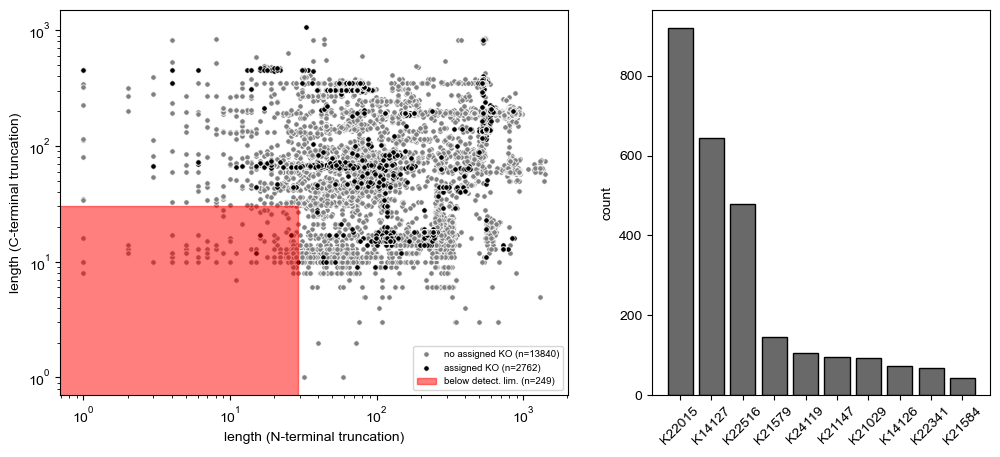

In [7]:
# How to visualize the possible failture modes on known selenoproteins?
# Truncate from either terminus with no minimum sequence length. Everything can be truncated at the C-terminus, but
# if there is no other potential start codon, then there is no reason for an ORF finder to detect a sequence that's in-frame. 

# Want to see if there are sequences which cannot be detected if truncated at the C-terminus, and also cannot be truncated at the N-terminus.
def figure_1(metadata_sec_df:pd.DataFrame, path:str='../figures/datasets-figure_1.png'):

    fig, axes = plt.subplots(ncols=2, figsize=(12, 5), width_ratios=[0.6, 0.4])

    ax = axes[0]
    metadata_sec_trunc_n_df = truncate_sec(metadata_sec_df, min_length=1, terminus='n', drop_failures=False, allowed_starts=['M', 'V'])
    metadata_sec_trunc_c_df = truncate_sec(metadata_sec_df, min_length=1, terminus='c', drop_failures=False)

    trunc_n_lengths = metadata_sec_trunc_n_df.seq.fillna(' ').apply(len).values
    trunc_c_lengths = metadata_sec_trunc_c_df.seq.fillna(' ').apply(len).values
    n_below_limit = ((trunc_c_lengths < 30) & (trunc_n_lengths < 30)).sum()

    mask = metadata_sec_df.e_value.isnull()
    ax.scatter(trunc_n_lengths[mask], trunc_c_lengths[mask], s=15, color='gray', edgecolors='white', lw=0.5, label=f'no assigned KO (n={mask.sum()})')
    ax.scatter(trunc_n_lengths[~mask], trunc_c_lengths[~mask], s=15, color='black', edgecolors='white', lw=0.5, label=f'assigned KO (n={(~mask).sum()})')
    ax.fill_between(np.arange(30), 30, color='red', alpha=0.5, label=f'below detect. lim. (n={n_below_limit})')
    ax.set_xlabel('length (N-terminal truncation)')
    ax.set_ylabel('length (C-terminal truncation)')
    ax.legend(loc='lower right', fontsize='x-small')
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax = axes[1]
    heights = metadata_sec_df.ko.value_counts(dropna=True).values[:10]
    kos = metadata_sec_df.ko.value_counts(dropna=True).index[:10]
    positions = np.arange(len(kos))
    ax.bar(positions, heights, color='dimgray', edgecolor='black')
    ax.set_xticks(positions, kos, rotation=45)
    ax.set_ylabel('count')

    plt.savefig(path)
    plt.show()

figure_1(metadata_sec_df)

truncate_sec: Truncating selenoproteins...: 100%|██████████| 16602/16602 [00:00<00:00, 709622.48it/s]

truncate_sec: Failed to truncate 256 selenoproteins at the N-terminus.


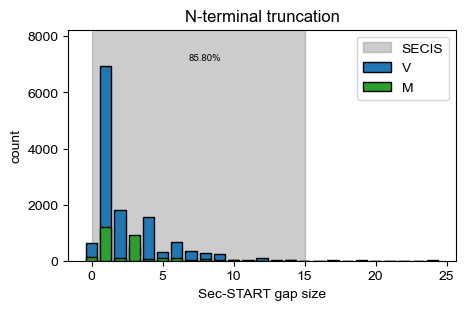

In [7]:
# I am also curious about how much distance between the U residue and next possible start there tends to be in the case of N-terminal truncation.
# Begs the question, what is the "right" way to do N-terminal truncation? Maybe try both? Don't want the model to just prefer sequences
# that start with Valine. Maybe take a look at the result of the 3c classifier before deciding. 

allowed_starts = ['V', 'M'] #, 'L']
alphas = {'M':1, 'V':0.7, 'L':0.5}
colors = {'M':'tab:green', 'V':'tab:blue', 'L':'tab:red'}

metadata_sec_trunc_n_df = truncate_sec(metadata_sec_df, terminus='n', drop_failures=True, allowed_starts=allowed_starts, min_length=30, bias='length')
metadata_sec_trunc_n_df['start_amino_acid'] = metadata_sec_trunc_n_df.seq.apply(lambda s : s[0]) 

# With no gap, trunc_size = sec_index_c.
sec_to_start_sizes = metadata_sec_trunc_n_df.trunc_size - metadata_sec_trunc_n_df.sec_index_c 
max_sec_to_start_size = 100
# Based on this https://academic.oup.com/nar/article/31/8/2234/1089166, it seems that SECIS may be picked up in the embedding when gaps are smaller than ~50 bp, 
# which would be about 16 amino acids. 
secis_boundary = 16

# , color='gray', edgecolor='black', label='gap sizes'
fig, ax = plt.subplots(figsize=(5, 3))

ax.fill_between(np.arange(secis_boundary), len(metadata_sec_trunc_n_df), color='gray', alpha=0.4, label='SECIS')

bins = 25
bottom, positions = np.zeros(bins), np.arange(bins)
for aa in metadata_sec_trunc_n_df.start_amino_acid.unique():
    mask = (metadata_sec_trunc_n_df.start_amino_acid == aa) & (sec_to_start_sizes < max_sec_to_start_size)
    heights, bin_edges = np.histogram(sec_to_start_sizes[mask], bins=bins)
    ax.bar(positions, heights, label=aa,  color=colors[aa], edgecolor='black')
    bottom += heights
    bins = bins

ax.text(secis_boundary / 2, max(bottom) - 1000, f'{(sec_to_start_sizes < secis_boundary).sum() / len(sec_to_start_sizes) * 100:.2f}%', ha='center', fontsize='x-small')
ax.legend()
ax.set_xlabel('Sec-START gap size')
ax.set_ylabel('count')
ax.set_ylim(0, max(bottom) + 100)
ax.set_title('N-terminal truncation')

plt.show()

# Want to look a bit more into whether or not I think Prodigal is more biased towards length or codon usage. Could do this by looking at instances
# where Prodigal predicts a shorter protein by preferring an ATG to an alternative stop... And as reference, possibly just look at cases where an alternative stop is 
# selected over an ATG to make a longer sequence? Not sure if this is the right thing to do, although if this NEVER happens, that's a pretty good indication
# that Prodigal's primary preference is for ATG starts. 
    

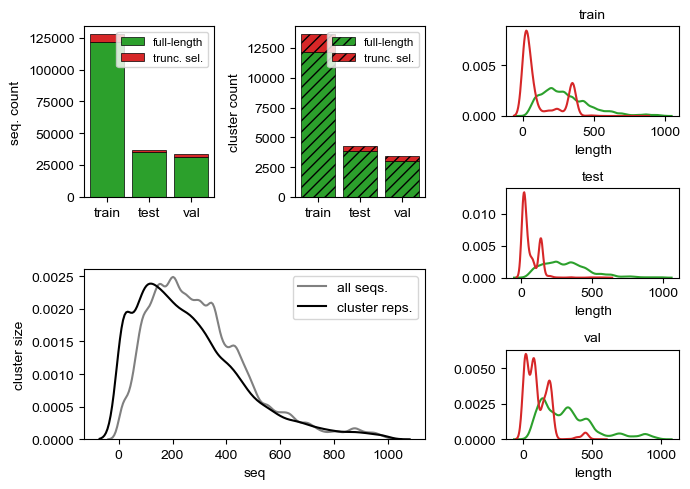

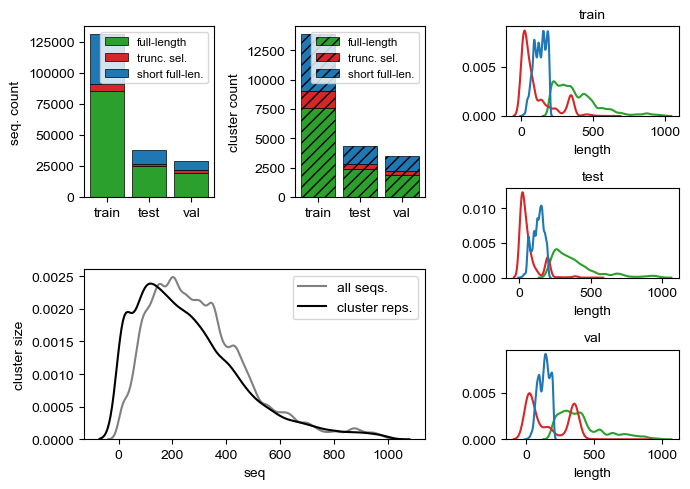

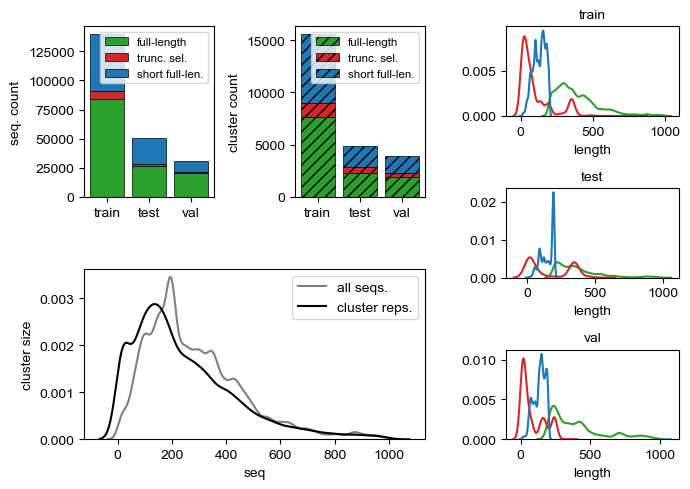

In [12]:
def figure_2(metadata_df:dict, path:str='../figures/datasets-figure_2.png'):
    '''Illustrating the composition of each split dataset.'''
    datasets = ['train', 'test', 'val']
    metadata_df.dataset = metadata_df.dataset.astype('category').cat.set_categories(datasets, ordered=True)

    fig = plt.figure(layout='tight', figsize=(7, 5))
    grid = GridSpec(6, 3, figure=fig, width_ratios=[0.3, 0.3, 0.4])

    ax_a = [fig.add_subplot(grid[:3, 0]), fig.add_subplot(grid[:3, 1])]
    ax_b = fig.add_subplot(grid[3:6, :2])
    ax_c = [fig.add_subplot(grid[i:i + 2, 2]) for i in range(0, 6, 2)]

    labels = sorted(metadata_df.label.unique())

    def figure_2a(ax:plt.Axes, heights:list, y_label:str=None, **kwargs):
        positions, bottom = np.arange(len(datasets)), np.zeros(len(datasets))
        for label in labels:
            ax.bar(positions, heights[label], bottom=bottom, color=color_map[label], edgecolor='black', lw=0.5, **kwargs)
            bottom += heights[label]
        ax.set_ylabel(y_label)
        ax.set_xticks(positions, labels=datasets)
        ax.legend([label_map[label] for label in labels], loc='upper right', fontsize='small')

    heights = [metadata_df.groupby('dataset').apply(lambda df : (df['label'] == l).sum()).values for l in labels]
    figure_2a(ax_a[0], heights, y_label='seq. count')

    heights = [metadata_df.groupby('dataset').apply(lambda df : df[df['label'] == l].mmseqs_cluster.nunique()).values for l in labels]
    figure_2a(ax_a[1], heights, y_label='cluster count', hatch='///')

    metadata_reps_df = metadata_df[metadata_df.index.isin(metadata_df.mmseqs_representative.unique())]
    sns.kdeplot(metadata_df.seq.apply(len), color='gray', ax=ax_b, label='all seqs.')
    sns.kdeplot(metadata_reps_df.seq.apply(len), color='black', label='cluster reps.', ax=ax_b)
    ax_b.set_ylabel('density')
    ax_b.set_ylabel('cluster size')
    ax_b.legend()

    for ax, dataset in zip(ax_c, datasets):
        for label, df in metadata_df[metadata_df.dataset == dataset].groupby('label'):
            sns.kdeplot(df.seq.apply(len), ax=ax, color=color_map[label], label=label)
        ax.set_title(dataset, fontsize='medium')
        # ax.set_ylabel('count')
        ax.set_xlabel('length')
        ax.set_ylabel('')
    
    fig.savefig(path)
    plt.show()


figure_2(metadata_2c_df, path='../figures/datasets-figure_2_2c.png')
figure_2(metadata_3c_df, path='../figures/datasets-figure_2_3c.png')
figure_2(metadata_3c_xl_df, path='../figures/datasets-figure_2_3c_xl.png')

# What I really want to show is the number of clusters for each label in each dataset, which I think might be more relevant to model training. 


In [9]:
# What are the truncation ratio distributions for the selenoprotein? How short is the shortest one?

# def figure_3()
# metadata_2c_1_df = pd.concat([df[df.label == 1].assign(dataset=dataset) for dataset, df in metadata_2c.items()]) # Grab all truncated selenoproteins. 
# metadata_2c_0_df = pd.concat([df[df.label == 0].assign(dataset=dataset) for dataset, df in metadata_2c.items()]) # Grab all truncated selenoproteins. 

# fig, axes = plt.subplots(ncols=2, figsize=(8, 5), width_ratios=[0.6, 0.4], layout='tight')

# ax = axes[0]

# colors = metadata_2c_1_df.dataset.replace(color_map).values
# ax.scatter(metadata_2c_1_df.original_length, metadata_2c_1_df.truncation_ratio, s=25, c=colors, edgecolors='black', lw=0.5)
# ax.set_xlabel('pre-trunc. length')
# ax.set_ylabel('trunc. ratio')
# ax.legend(handles=[Patch(facecolor=color_map[dataset], label=dataset, edgecolor='black') for dataset in datasets], loc='lower right')

# ax = axes[1]
# ax.hist(metadata_2c_1_df.seq.apply(len), bins=15, width=40, edgecolor='black', color='gray')
# ax.set_ylabel('log(count)')
# ax.set_xlabel('trunc. length')
# ax.set_yscale('log')
# ax.text(0.5, 0.9, f'min. length = {metadata_2c_1_df.seq.apply(len).min()}\nmax. length = {metadata_2c_1_df.seq.apply(len).max()}', transform=ax.transAxes, fontsize='small')

# plt.show()

58817 80764


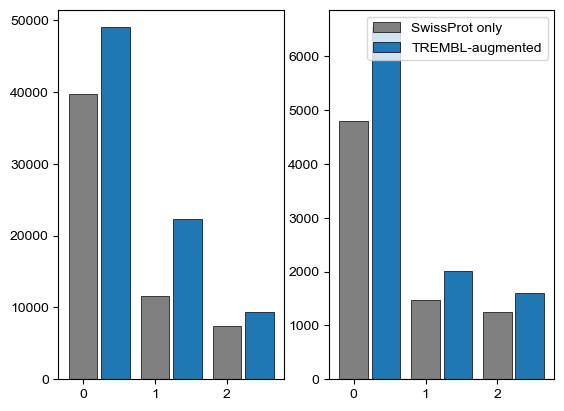

In [10]:
# How much did augmenting with TREMBL actually help? Want to make sure to compare the number of homology
# clusters to get a better sense of the statistical power of the augmentation. 
def figure_3(metadata_df, metadata_xl_df):
    fig, axes = plt.subplots(ncols=2)

    metadata_df = metadata_df[metadata_df.label == 2]
    metadata_xl_df = metadata_xl_df[metadata_xl_df.label == 2]
    print(len(metadata_df), len(metadata_xl_df))

    positions = np.arange(3)
    ax = axes[0]
    bar_width = 0.4
    offset = bar_width + 0.05
    colors = ['gray', 'tab:blue']
    for i, df in enumerate([metadata_df, metadata_xl_df]):
        heights = df.groupby('dataset').apply(len)
        ax.bar(positions + i * offset, heights, color=colors[i], edgecolor='black', lw=0.5, width=bar_width)

    ax = axes[1]
    bar_width = 0.4
    offset = bar_width + 0.05
    colors = ['gray', 'tab:blue']
    for i, df in enumerate([metadata_df, metadata_xl_df]):
        heights = df.groupby('dataset').apply(lambda df : df.mmseqs_cluster.nunique())
        ax.bar(positions + i * offset, heights, color=colors[i], edgecolor='black', lw=0.5, width=bar_width)

    ax.legend(['SwissProt only', 'TREMBL-augmented'])
    
    plt.show()

figure_3(metadata_3c_df, metadata_3c_xl_df)

In [11]:
metadata_3c_df.value_counts('label')


label
0    129739
2     58817
1      9231
Name: count, dtype: int64